In [2]:
import tellurium as te
import cobra, settings, re, os
from cobra.util import create_stoichiometric_matrix
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import tempfile
% matplotlib inline

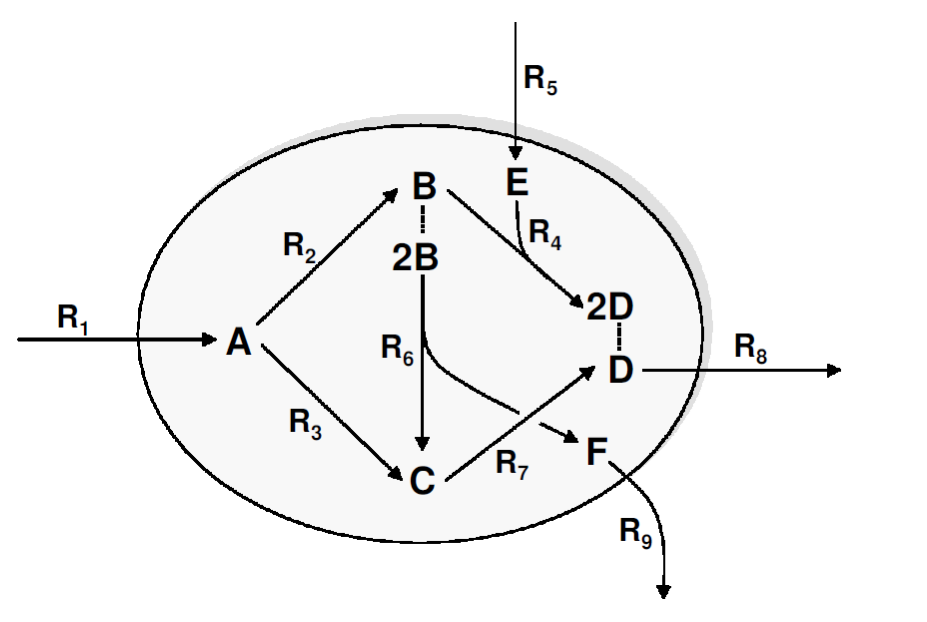

In [3]:
from IPython.display import Image
Image(settings.DATA_DIR+"/test_model.png")

In [4]:
model = cobra.Model('example_model')

a = ['A_e --> A',
     'A --> B',
     'A --> C',
     'B + E --> 2 D',
     'E_e --> E',
     '2 B --> C + F',
     'C --> D',
     'D --> D_e',
     'F --> F_e',
    ];

## generate all reactions and metabolites
R1 = cobra.Reaction('R1')
R2 = cobra.Reaction('R2')
R3 = cobra.Reaction('R3')
R4 = cobra.Reaction('R4')
R5 = cobra.Reaction('R5')
R6 = cobra.Reaction('R6')
R7 = cobra.Reaction('R7')
R8 = cobra.Reaction('R8')
R9 = cobra.Reaction('R9')

R10 = cobra.Reaction('R10')
R11 = cobra.Reaction('R11')
R12 = cobra.Reaction('R12')
R13 = cobra.Reaction('R13')

A = cobra.Metabolite('A')
B = cobra.Metabolite('B')
C = cobra.Metabolite('C')
D = cobra.Metabolite('D')
E = cobra.Metabolite('E')
F = cobra.Metabolite('F')

A_e = cobra.Metabolite('A_e')
E_e = cobra.Metabolite('E_e')
D_e = cobra.Metabolite('D_e')
F_e = cobra.Metabolite('F_e')

R1.add_metabolites({A_e: -2.0, A: 1.0})
R2.add_metabolites({A: -1.0, B: 1.0})
R3.add_metabolites({A: -1.0, C: 1.0})
R4.add_metabolites({B: -1.0, E: -1.0, D: 2.0})
R5.add_metabolites({E_e: -1.0, E: 1.0})
R6.add_metabolites({B: -2.0, C: 1.0, F: 1.0})
R7.add_metabolites({C: -1.0, D: 1.0})
R8.add_metabolites({D_e: 1.0, D: -1.0})
R9.add_metabolites({F_e: 1.0, F: -1.0})

R10.add_metabolites({A_e: 1.0})
R11.add_metabolites({E_e: 1.0})
R12.add_metabolites({D_e: -1.0})
R13.add_metabolites({F_e: -1.0})

model.add_reactions([R1, R2, R3, R4, R5, R6,R7, R8, R9, R10, R11, R12, R13])

for x in model.reactions:
    print("%s : %s" % (x.id, x.reaction))

R1 : 2.0 A_e --> A
R2 : A --> B
R3 : A --> C
R4 : B + E --> 2.0 D
R5 : E_e --> E
R6 : 2.0 B --> C + F
R7 : C --> D
R8 : D --> D_e
R9 : F --> F_e
R10 :  --> A_e
R11 :  --> E_e
R12 : D_e --> 
R13 : F_e --> 


In [5]:
model.objective = 'R8'
model.reactions.get_by_id('R1').bounds = [0,10]
flux_solution = model.optimize().fluxes
flux_solution

R1     10.0
R2     10.0
R3      0.0
R4     10.0
R5     10.0
R6      0.0
R7      0.0
R8     20.0
R9      0.0
R10    20.0
R11    10.0
R12    20.0
R13     0.0
Name: fluxes, dtype: float64

In [6]:
columns = [rxn.id for rxn in model.reactions]
index = [met.id for met in model.metabolites]
S = pd.DataFrame(create_stoichiometric_matrix(model), index=index, columns=columns)

def remove_mets_rxns(S, rxns=[], mets=[]):
    """generic function for the removal of reactions and metabolites from the stoichiometric matrix"""

    if not set(rxns).issubset(set(S.columns)):
        no_match = list(set(rxns).difference(set(S.columns)))
        raise ValueError('Reactions %s do not occur in the Stoichiometrix matrix' % no_match)
    else:
        S_sub = S.drop(rxns, axis=1)
        if not (S_sub.T != 0).any().all():
            raise AssertionError('removal of reactions results in removal of metabolites')    
        
    return S_sub

rxns = [rxn.id for rxn in model.reactions if rxn.boundary]
S_sub = remove_mets_rxns(S, rxns)

In [111]:
class model:

    def __init__(self, S):
    
        self.S = S
        self.P = dict.fromkeys([x+'_0' for x in S.index])
        self.X0 = dict.fromkeys(S.index)
        self.rxns = dict.fromkeys(S.columns)
        self.rates = dict.fromkeys(S.columns)
        self.vmax = dict.fromkeys(['Vmaxf_'+x for x in S.columns])
        self.exchange = [x for x in S.index if x.endswith('_e')]
        self.mapping = dict()
        
        ## add the reaction formula
        for rxn in self.rxns:
            subs, prods = [],[]
            mets = [str(self.S[rxn][i])+' '+i for i in (self.S[rxn]!=0)[self.S[rxn]!=0].index]
            for met in mets:
                c, m = met.split(' ')
                if float(c) < -1: 
                    subs += [c[1:]+' '+m]
                elif float(c) == -1:
                    subs += [m]
                elif float(c) > 1:
                    prods += [c+' '+m]
                elif float(c) == 1:
                    prods += [m]
            self.rxns[rxn] = ' + '.join(subs)+' -> '+' + '.join(prods)

    def add_rate(self, rxn): # reversible MM with haldane
        f, b, MAp, MAs = ([] for i in range(4))
        mets = [str(model.S[rxn][i])+' '+i for i in (model.S[rxn]!=0)[model.S[rxn]!=0].index]
        
        unity = 'unity'; Vmaxf = 'Vmaxf_'+rxn; Vmaxb = 'Vmaxb_'+rxn; Keq = 'Keq_'+rxn; v = 'v_'+rxn
        self.P[Vmaxf] = None; self.P[v] = None; self.P[unity] = None;
               
        for met in mets:
            c, m = met.split(' ')
            Km = '_'.join(['Km',rxn,m])
            self.P[Km] = None
            
            if float(c) < -1: 
                f += [m+' ^ '+c[1:]+' / '+Km];
                MAs += [m+' ^ '+c[1:]]
            elif float(c) == -1:
                f += [m+' / '+Km]
                MAs += [m]
            elif float(c) > 1:
                b += [m+' ^ '+c+' / '+Km]
                MAp += [m+' ^ '+c]
            elif float(c) == 1:
                b += [m+' / '+Km]
                MAp += [m]
    
        law = 'Haldane'
        
        # irreversible mass action
        if law == 'irrev_MA': 
            rate = Vmaxf+' * '+' * '.join(MAs)
            vmax = v+' / '+' * '.join(MAs)

        # reversible mass action
        elif law == 'rev_MA': 
            rev = 'rev_'+rxn
            self.P[rev] = None
            v_f = v+' * ( '+unity+' + '+rev+' )'; v_b = v+' * '+rev
            rate = Vmaxf+' * '+' * '.join(MAs)+' - '+Vmaxb+' * '+' * '.join(MAp)
            vmax = v_f+' / ( '+' * '.join(MAs)+' )'
            vmaxb = v_b+' / ( '+' * '.join(MAp)+' )'
            self.vmax[Vmaxb] = vmaxb
            self.P[Vmaxb] = None
            
        # modified mass action    
        elif law == 'mod_rev_MA':
            self.P[Keq] = None;
            rate = Vmaxf+' * '+' * '.join(MAs)+' ( '+unity+' - ( '+' * '.join(MAp)+' / '+' * '.join(MAs)+' / '+Keq+' ) )'
            vmax = v+' / ('+' * '.join(MAs)+' ( '+unity+' - ( '+' * '.join(MAp)+' / '+' * '.join(MAs)+' / '+Keq+' ) ) )'
        
        # reversible michaelis-menten with haldane substitution    
        elif law == 'Haldane': 
            self.P[Keq] = None;
            rev = '( '+unity+' - ( '+' * '.join(MAp)+' / '+' * '.join(MAs)+' ) / '+Keq+' )'
            num = ' * '.join(f)
            den = '( '+unity+' + '+' + '.join(f)+' + '+' + '.join(b)+' )'
            rate = '( '+Vmaxf+' * '+rev+' * '+num+' / '+den+' )'
            vmax = '( '+v+' / ( '+rev+' * '+num+' / '+den+' ) )'
        
        self.rates[rxn] = rate
        self.vmax[Vmaxf] = vmax
    
    def map_names(self):
        for i,met in enumerate(self.X0):
            self.mapping[met] = 'S'+str(i)
        for i,par in enumerate(self.P):
            self.mapping[par] = 'P'+str(i)
        for i,rxn in enumerate(self.rxns): 
            self.mapping[rxn] = 'R'+str(i)
        self.mapping.update({v: k for k, v in self.mapping.items()})
    
    def parameterize(self, flux_solution): 
        
        def get_truncnorm(mean=0, sd=1, lb=0, ub=10):
            return truncnorm((lb - mean) / sd, (ub - mean) / sd, loc=mean, scale=sd)
        
        for k,v in self.P.items():
            if k[2:] in flux_solution.index: ## 'v_'+rxn
                self.P[k] = str(float(flux_solution.loc[k[2:]]))
            elif k.startswith('rev_'): # reversibility
                self.P[k] = str(np.random.uniform(0.2,0.8))
            elif k.startswith('Keq_'): # reversibility
                self.P[k] = str(np.random.uniform(0.2,0.8))    
            else:
                self.P[k] = str(get_truncnorm(mean=1, sd=1, lb=0.1, ub=10).rvs())
                
        for k,v in self.X0.items(): # set initial conditions, generate a parameter as well for Vmax
            val = str(get_truncnorm(mean=1, sd=1, lb=0.1, ub=3).rvs())
            self.X0[k] = val
            self.P[k+'_0'] = val
            
        for k,v in self.vmax.items(): # rewrite in terms of initial conditions
            self.vmax[k] = ' '.join([i+'_0' if i in self.X0 else i for i in v.split(' ')]) 
        
        self.P['unity'] = str(1)
                
                
    def to_antimony(self):
    
        def convert_string(string):
            return ' '.join([self.mapping[x] if x in self.mapping else x for x in string.split(' ')])
        
        def calculate_vmax(vmax):
            return str(eval(' '.join([self.P[x] if x in self.P else x for x in vmax.split(' ')]).replace('^','**')))
        
        antimony_model = ''''''
        antimony_model += '// model *coli_core()'

        antimony_model += '\n\n// Reactions:'
        
        for rxn, formula in self.rxns.items():
            for ex in self.exchange:
                if ex in formula:
                    formula = formula.replace(ex,'$ '+ex) ## $ sets it steady
            antimony_model += '\n'+self.mapping[rxn]+': '+convert_string(formula)+'; '+convert_string(self.rates[rxn])+';'

        antimony_model += '\n\n// Initial conditions:\n'
        for met, value in self.X0.items():
            antimony_model += ''+self.mapping[met]+' = '+value+'; '

        antimony_model += '\n\n// Parameters:\n'
        for par, value in self.P.items():
            antimony_model += ''+self.mapping[par]+' = '+value+'; '

        antimony_model += '\n\n// Derived parameters:'
        for rxn, vmax in self.vmax.items():
            vmax = calculate_vmax(vmax) # vmax = convert_string(vmax)
            antimony_model += '\n '+self.mapping[rxn]+' = '+vmax+'; '

        return antimony_model

model = model(S_sub)

for rxn in model.rates:
    model.add_rate(rxn)

model.map_names()
np.random.seed(61) # 61

model.parameterize(flux_solution)

antimony_model = model.to_antimony()


In [112]:
def add_event(antimony_model, time='', event=''):
    antimony_model += '\nat (time > '+time+'): '+event+';' 
    return antimony_model

def perturb(antimony_model):
    antimony_model += '\n\n //Events: '
    antimony_model = add_event(antimony_model, time='10', event='S0 = S0 * 0.9')
    antimony_model = add_event(antimony_model, time='20', event='S0 = %s' % model.P['A_e_0'])
    return antimony_model

antimony_model = perturb(antimony_model)


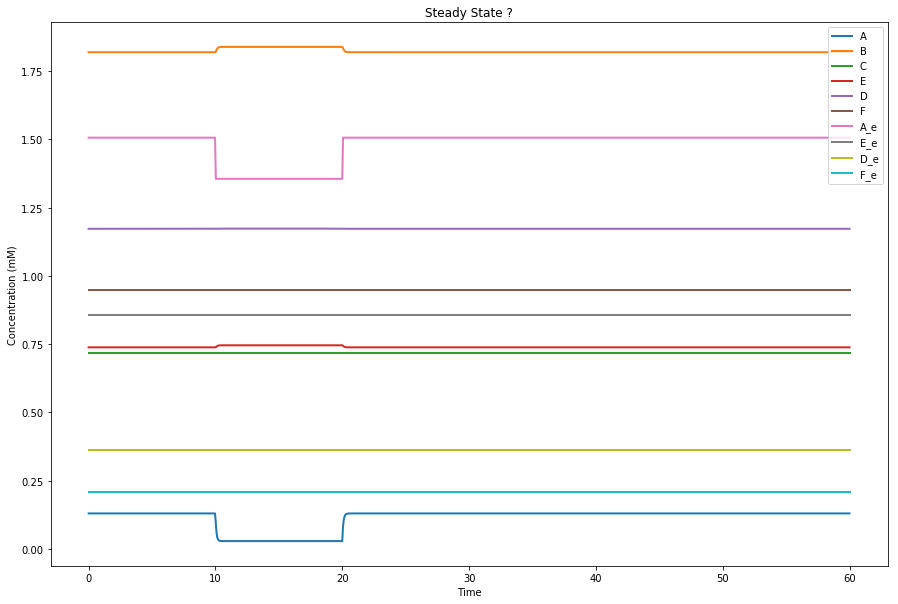

809

In [114]:
r = te.loada(antimony_model) 
r.timeCourseSelections= ['time'] + r.getFloatingSpeciesIds() + r.getBoundarySpeciesIds()
sim_data = r.simulate(0,60,1000)
fig = plt.figure(figsize=(15,10))
new = [model.mapping[x] for x in r.getFloatingSpeciesIds()+ r.getBoundarySpeciesIds()]
te.plotArray(sim_data, ylabel='Concentration (mM)', xlabel='Time',
            title='Steady State ?', labels=new)
a

In [115]:
print(antimony_model)

// model *coli_core()

// Reactions:
R2: 2.0 $ S0 -> S1; ( P10 * ( P12 - ( S1 / S0 ^ 2.0 ) / P15 ) * S0 ^ 2.0 / P13 / ( P12 + S0 ^ 2.0 / P13 + S1 / P14 ) );
R3: S1 -> S2; ( P16 * ( P12 - ( S2 / S1 ) / P20 ) * S1 / P18 / ( P12 + S1 / P18 + S2 / P19 ) );
R4: S1 -> S3; ( P21 * ( P12 - ( S3 / S1 ) / P25 ) * S1 / P23 / ( P12 + S1 / P23 + S3 / P24 ) );
R5: S2 + S4 -> 2.0 S5; ( P26 * ( P12 - ( S5 ^ 2.0 / S2 * S4 ) / P31 ) * S2 / P28 * S4 / P29 / ( P12 + S2 / P28 + S4 / P29 + S5 ^ 2.0 / P30 ) );
R6: $ S6 -> S4; ( P32 * ( P12 - ( S4 / S6 ) / P36 ) * S6 / P35 / ( P12 + S6 / P35 + S4 / P34 ) );
R7: 2.0 S2 -> S3 + S7; ( P37 * ( P12 - ( S3 * S7 / S2 ^ 2.0 ) / P42 ) * S2 ^ 2.0 / P39 / ( P12 + S2 ^ 2.0 / P39 + S3 / P40 + S7 / P41 ) );
R8: S3 -> S5; ( P43 * ( P12 - ( S5 / S3 ) / P47 ) * S3 / P45 / ( P12 + S3 / P45 + S5 / P46 ) );
R9: S5 -> $ S8; ( P48 * ( P12 - ( S8 / S5 ) / P52 ) * S5 / P50 / ( P12 + S5 / P50 + S8 / P51 ) );
R8: S7 -> $ S9; ( P53 * ( P12 - ( S9 / S7 ) / P57 ) * S7 / P55 / ( P12 + S7 